***

**XGBoost - Model**

The following notebook contains an example XGBoost model that uses PCA features.

***

- **Required Libraries:**

In [1]:
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [2]:
# Load our feature dataset.
features = pd.read_csv("../data/PCA_Features.csv")
features

,0,1,2,3,4,5,6,7,8,Label
0,0.654454,-0.099824,0.749483,0.676999,-0.364040,-0.639647,0.336693,0.926019,-0.170667,0.0
1,-0.562398,-0.715807,0.413918,-0.625886,0.041396,-0.778815,-0.540347,0.697070,0.471294,0.0
2,-0.592244,-0.666728,0.452460,-0.648727,0.061493,-0.758533,-0.477912,0.742760,0.468943,1.0
3,-0.551164,-0.738807,0.387792,-0.602412,0.030763,-0.797592,-0.577337,0.673215,0.462022,1.0
4,-0.762062,-0.539914,0.357428,-0.511812,0.164145,-0.843270,-0.396624,0.825560,0.401423,1.0
...,...,...,...,...,...,...,...,...,...,...
992,0.791593,0.599121,0.120140,0.450649,-0.439625,-0.776946,0.412668,-0.669167,0.617997,1.0
993,0.773551,0.572184,0.272442,0.518675,-0.324604,-0.790954,0.364135,-0.753152,0.547876,1.0
994,-0.902531,-0.346831,0.255239,-0.375057,0.341869,-0.861660,-0.211592,0.873404,0.438628,1.0
995,-0.827475,-0.462166,0.318885,-0.535700,0.479613,-0.694979,-0.168255,0.745905,0.644450,1.0


In [3]:
# Separate data into predictors (X) and label (y).
X = features.drop(["Label"], axis = 1)
y = features["Label"]

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 226)

In [4]:
# Convert sets into DMatrices (required by XGBoost).
d_train = xgb.DMatrix(X_train, label = y_train)
d_test = xgb.DMatrix(X_test, label = y_test)

- The following dictionary contains the default hyperparameters for XGBoost.
  - `"objective": "binary:hinge"` tells XGBoost we are doing binary classification.
  - `"eval_metric": "mae"` means we are using the Mean Absolute Error (MAE) as an evaluation metric.

In [5]:
parameters = {

    # Parameters for Tree Booster
    "max_depth": 6,
    "min_child_weight": 1,
    "eta": 0.3,
    "subsample": 1.0,
    "colsample_bytree": 1.0,

    # Learning Task Parameters
    "objective": "binary:hinge",
    "eval_metric": "mae"
}

In [6]:
# Train a model with the training set and the default parameter dictionary.
model = xgb.train(parameters, d_train, num_boost_round = 100)

In [7]:
# Use model to make a prediction of the testing set.
y_pred = model.predict(d_test)

In [8]:
# Get the accuracy score of our prediction.
accuracy_score(y_pred, y_test) * 100

92.0

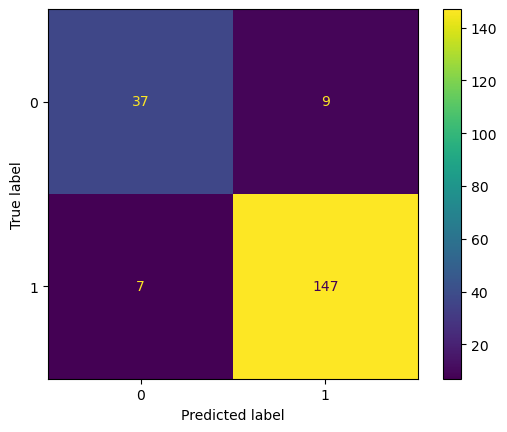

In [9]:
# Plot a confusion matrix of the prediction.
conf_matrix = confusion_matrix(y_test, y_pred)
cofn_plt = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cofn_plt.plot()
plt.show()